I want to make a prediction!

I found some great leads on ML for time-series prediction here:

http://machinelearningmastery.com/promise-recurrent-neural-networks-time-series-forecasting/

http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

I'll try to use the Long Short-Term Memory (LSTM) Recurrent Neural Network for this prediction.



These tutorials use a simple dataset to perform a straigh-forward prediction. I will break down our problem into several steps, each increasing the complication of the problem:

1. Predict a player's goal scoring based on their past few season's stats - use games played & goals.
2. Predict a player's goal scoring based on their past few season's stats - use many stat categories
3. Predict a player's performance in a number of stat categories based on their recent performance.
4. Predict a player's goal scoring based on many players' past few seasons' performance.


I think I'll start with Ovi's stats. I know he has a number of years in the league and I know his player ID.



Copying from 

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

and modified for ML4NHL




Set up the workspace:

In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
#from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


Define a function to alter a series for ML problems

In [7]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

Define some more functions:

In [8]:
# create a differenced series
#def difference(dataset, interval=1):
#	diff = list()
#	for i in range(interval, len(dataset)):
#		value = dataset[i] - dataset[i - interval]
#		diff.append(value)
#	return Series(diff)
 
# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Functions defined!

Let's try to apply this....

In [9]:
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

statspd=read_csv('NHL_skater_stats_2011-2016.csv')#,header=None)

Okay, first we'll just need a single player's GP and goals. Extract from the stats dataframe.

We're going to analyze Alex Ovechkin, whose player id is 8471214. 

In [10]:
OVIstats = statspd.drop(statspd.index[statspd.PlayerId != 8471214])

OVIstats

,﻿Season,Assists,FaceoffWinPctg,GameWinningGoals,GamesPlayed,Goals,OTGoals,PenaltyMinutes,PlayerFirstName,PlayerId,...,Points,PPGoals,PPPoints,SHGoals,SHPoints,ShiftsPerGame,ShootingPctg,Shots,TeamAbbrev,TimeOnIcePerGame
2,20112012,31,0.4375,4,92,43,2,34,Alex,8471214,...,74,15,27,0,0,21.4782,0.1218,353,NaN,1188.4891
1235,20122013,25,0.0000,4,55,33,0,40,Alex,8471214,...,58,17,29,0,0,21.3818,0.1320,250,NaN,1251.9454
2495,20132014,28,0.6666,10,78,51,3,48,Alex,8471214,...,79,24,39,0,1,21.7948,0.1321,386,NaN,1232.7179
3144,20142015,32,0.5000,11,95,58,0,64,Alex,8471214,...,90,26,36,0,0,22.8105,0.1271,456,NaN,1216.2526
4126,20152016,28,0.0000,9,91,55,2,55,Alex,8471214,...,83,22,31,0,0,22.0000,0.1195,460,NaN,1226.5384


In [11]:
print(OVIstats.columns)

Index(['﻿Season', 'Assists', 'FaceoffWinPctg', 'GameWinningGoals',
       'GamesPlayed', 'Goals', 'OTGoals', 'PenaltyMinutes', 'PlayerFirstName',
       'PlayerId', 'PlayerLastName', 'PlayerName', 'PlayerPositionCode',
       'PlusMinus', 'Points', 'PPGoals', 'PPPoints', 'SHGoals', 'SHPoints',
       'ShiftsPerGame', 'ShootingPctg', 'Shots', 'TeamAbbrev',
       'TimeOnIcePerGame'],
      dtype='object')


Okay, let's pare this down to only the stats we need...

In [12]:
OVIstats.drop(['﻿Season','Assists', 'FaceoffWinPctg', 'GameWinningGoals','GamesPlayed', 'OTGoals', 'PenaltyMinutes', 'PlayerFirstName',
       'PlayerId', 'PlayerLastName', 'PlayerName', 'PlayerPositionCode',
       'PlusMinus', 'Points', 'PPGoals', 'PPPoints', 'SHGoals', 'SHPoints',
       'ShiftsPerGame', 'ShootingPctg', 'Shots', 'TeamAbbrev',
       'TimeOnIcePerGame'], axis=1, inplace=True)
OVIstats.rename(columns={'﻿Season': 'Season'}, inplace=True)



OVIstats

,Goals
2,43
1235,33
2495,51
3144,58
4126,55


Manipulating the data has been easy via Pandas, but the flow will need the data in a Numpy array.

In [13]:
type(OVIstats)

pandas.core.frame.DataFrame

In [14]:
#OVIseries = numpy.array(OVIstats.values)

#OVIseries

In [15]:
# transform data to be stationary
raw_values = OVIstats.values
#diff_values = difference(raw_values, 1)

In [16]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(raw_values,1)#diff_values, 1)
supervised_values = supervised.values[1:]

In [17]:
supervised

,0,0
0,0.0,43
1,43.0,33
2,33.0,51
3,51.0,58
4,58.0,55


In [19]:
supervised_values

array([[ 43.,  33.],
       [ 33.,  51.],
       [ 51.,  58.],
       [ 58.,  55.]])

In [20]:
# split data into train and test-sets
train, test = supervised_values[:], supervised_values[:]

In [21]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [22]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1000, 2)

In [23]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.99137849],
       [ 0.43627858],
       [ 0.99557692],
       [ 0.7605288 ]], dtype=float32)

In [24]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    ## invert differencing
    ##yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[i+1]#len(train) + i + 1]
    print('Year=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Year=1, Predicted=26.613765, Expected=33.000000
Year=2, Predicted=13.742517, Expected=51.000000
Year=3, Predicted=20.028113, Expected=58.000000
Year=4, Predicted=31.768531, Expected=55.000000


Test RMSE: 8.581


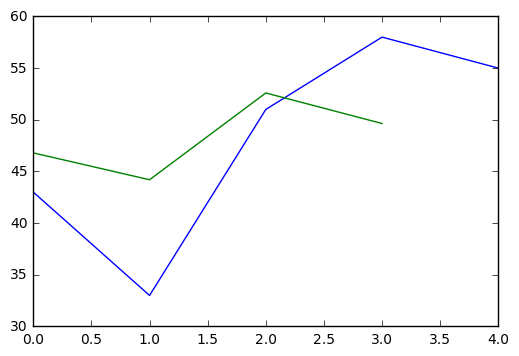

In [137]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[1:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[:])
pyplot.plot(predictions)
pyplot.show()